# AI That Makes music,  Classical + Lo-Fi Beats

In [3]:
'''Audio is a time-series signal — it's just a stream of numbers representing air pressure (sound waves) sampled at regular intervals.

For example, a 44.1 kHz .mp3 or .wav file means:
👉 44,100 numbers (samples) per second.'''

"Audio is a time-series signal — it's just a stream of numbers representing air pressure (sound waves) sampled at regular intervals.\n\nFor example, a 44.1 kHz .mp3 or .wav file means:\n👉 44,100 numbers (samples) per second."

## Data Pipeline
1. Data Collection
2. Preprocessing
3. Feature Extraction
4. Model Design
5. Training the Model
6. Generation (Inference)
7. Post-processing
8. Evaluation & Output


In [1]:
import soundfile as sf
import numpy as np
import librosa
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display

### 1. Data collection

In [ ]:
import zipfile
import os

# Step 1: Unzip the file
zip_path = '/Users/pratiibhas/Documents/Deep Learning/Projects/music.zip'  # Replace with your zip filename
extract_dir = 'extracted_audio'  # Folder to extract to

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 2: Find the audio file inside the extracted folder
# Assuming there is only one audio file
audio_file = None
for file in os.listdir(extract_dir):
    if file.endswith('.mp3') or file.endswith('.wav'):
        audio_file = os.path.join(extract_dir, file)
        break


In [ ]:
folder_path = '/Users/pratiibhas/Documents/Deep Learning/Projects/extracted_audio/music'  # Update this with the actual folder name
audio_file = None

# Step 1: Loop over the files and pick one
for file in os.listdir(folder_path):
    if file.endswith('.mp3') or file.endswith('.wav'):
        audio_file = os.path.join(folder_path, file)
        break  # load only the first audio file

# Step 2: Load the audio
audio, sr = librosa.load(audio_file, sr=None)
print("Sample rate:", sr)
print("Audio shape:", audio.shape)


### 2. Data Preprocessing

In [ ]:
# Parameters
input_folder = "extracted_audio/music"
output_folder = "split_clips"
clip_duration = 30  # in seconds
sample_rate = 22050  # standard for librosa, or use None to preserve original

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through all audio files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.mp3', '.wav', '.flac', '.m4a', '.ogg')):
        input_path = os.path.join(input_folder, filename)
        print(f"Processing: {filename}")

        # Load the audio
        audio, sr = librosa.load(input_path, sr=sample_rate)
        total_duration = librosa.get_duration(y=audio, sr=sr)
        num_clips = int(total_duration // clip_duration)

        # Output subfolder for each audio file
        base_name = os.path.splitext(filename)[0]
        file_output_folder = os.path.join(output_folder, base_name)
        os.makedirs(file_output_folder, exist_ok=True)

        # Split and save chunks
        for i in range(num_clips):
            start_sample = int(i * clip_duration * sr)
            end_sample = int((i + 1) * clip_duration * sr)
            clip = audio[start_sample:end_sample]

            out_filename = f"{base_name}_clip_{i+1:03d}.wav"
            out_path = os.path.join(file_output_folder, out_filename)
            sf.write(out_path, clip, sr)

        print(f"Saved {num_clips} clips to {file_output_folder}")


### Whisper 
 Whisper is a pre-trained model for automatic speech recognition (ASR) published in September 2022 by Alec Radford et al. from OpenAI.
 - First, the Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s. Examples shorter than this are padded to 30s by appending zeros to the end of the sequence (zeros in an audio signal correspond to no signal or silence)
 - Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.
 - The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-mel spectrograms. As you recall, these spectrograms describe how the frequencies of a signal change over time, expressed on the mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing.

In [4]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [5]:
# 1. Get all .wav file paths
split_clips_path = "extracted_audio/split_clips"
audio_file_paths = glob.glob(os.path.join(split_clips_path, "**", "*.wav"), recursive=True)
print(f"Found {len(audio_file_paths)} audio files.")

# 2. Create initial DataFrame with file paths
df = pd.DataFrame(audio_file_paths, columns=["file_path"])

# 3. Define a function to extract audio features
def extract_audio_features(path):
    try:
        y, sr = librosa.load(path, sr=16000)  # Force to 16kHz
        duration = librosa.get_duration(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        return pd.Series({
            "waveform": y,
            "sample_rate": sr,
            "duration": duration,
            "tempo": tempo
        })
    except Exception as e:
        print(f"Failed to process {path}: {e}")
        return pd.Series({
            "waveform": None,
            "sample_rate": None,
            "duration": None,
            "tempo": None
        })

# 4. Apply the function to all file paths
df = df.join(df["file_path"].apply(extract_audio_features))

# Optional: drop rows that failed to load
df = df.dropna(subset=["waveform"])
print(f"Successfully loaded {len(df)} audio examples.")


Found 1742 audio files.
Successfully loaded 1742 audio examples.


In [6]:
# updating fiile_path to filename
df['filename'] = df['file_path'].apply(os.path.basename)

In [7]:
d = df.copy()

In [8]:
d = d.drop('file_path', axis=1)
d

,waveform,sample_rate,duration,tempo,filename
0,"[0.0643428, 0.07880117, 0.0634036, 0.06240833,...",16000,30.0,[93.75],A playlist for night studies (Dark academia). ...
1,"[0.039544873, 0.0454032, 0.03786669, 0.0439170...",16000,30.0,[72.11538461538461],A playlist for night studies (Dark academia). ...
2,"[-0.09799327, -0.14246145, -0.1415363, -0.1585...",16000,30.0,[144.23076923076923],A playlist for night studies (Dark academia). ...
3,"[0.10783974, 0.14387067, 0.13118747, 0.1398961...",16000,30.0,[125.0],A playlist for night studies (Dark academia). ...
4,"[0.012674425, 0.017099608, 0.016961852, 0.0196...",16000,30.0,[117.1875],A playlist for night studies (Dark academia). ...
...,...,...,...,...,...
1737,"[-0.058558736, -0.07241667, -0.047160856, -0.0...",16000,30.0,[81.52173913043478],4 HOURS STUDY GIRL - Cozy lofi music and rain ...
1738,"[0.0052626217, 0.0062353956, 0.02467797, 0.032...",16000,30.0,[81.52173913043478],11 Acorn Lane - Mellow Mouser [Lofi Chillhop] ...
1739,"[-8.1356856e-13, -1.1424363e-13, -1.3312115e-1...",16000,30.0,[81.52173913043478],11 Acorn Lane - Mellow Mouser [Lofi Chillhop] ...
1740,"[0.073633134, 0.07453435, 0.06627098, 0.080649...",16000,30.0,[156.25],11 Acorn Lane - Mellow Mouser [Lofi Chillhop] ...


In [9]:
def extract_genre(file):
    if "classical" in file.lower() or "chopin" in file.lower() or "academia" in file.lower() or "night studies" in file.lower():
        return "classical"
    elif "lofi" in file.lower() or "chill" in file.lower() or "lo-fi" in file.lower():
        return "lo-fi"
    else:
        return "unknown"

d["genre"] = d["filename"].apply(extract_genre)

In [10]:
d

,waveform,sample_rate,duration,tempo,filename,genre
0,"[0.0643428, 0.07880117, 0.0634036, 0.06240833,...",16000,30.0,[93.75],A playlist for night studies (Dark academia). ...,classical
1,"[0.039544873, 0.0454032, 0.03786669, 0.0439170...",16000,30.0,[72.11538461538461],A playlist for night studies (Dark academia). ...,classical
2,"[-0.09799327, -0.14246145, -0.1415363, -0.1585...",16000,30.0,[144.23076923076923],A playlist for night studies (Dark academia). ...,classical
3,"[0.10783974, 0.14387067, 0.13118747, 0.1398961...",16000,30.0,[125.0],A playlist for night studies (Dark academia). ...,classical
4,"[0.012674425, 0.017099608, 0.016961852, 0.0196...",16000,30.0,[117.1875],A playlist for night studies (Dark academia). ...,classical
...,...,...,...,...,...,...
1737,"[-0.058558736, -0.07241667, -0.047160856, -0.0...",16000,30.0,[81.52173913043478],4 HOURS STUDY GIRL - Cozy lofi music and rain ...,lo-fi
1738,"[0.0052626217, 0.0062353956, 0.02467797, 0.032...",16000,30.0,[81.52173913043478],11 Acorn Lane - Mellow Mouser [Lofi Chillhop] ...,lo-fi
1739,"[-8.1356856e-13, -1.1424363e-13, -1.3312115e-1...",16000,30.0,[81.52173913043478],11 Acorn Lane - Mellow Mouser [Lofi Chillhop] ...,lo-fi
1740,"[0.073633134, 0.07453435, 0.06627098, 0.080649...",16000,30.0,[156.25],11 Acorn Lane - Mellow Mouser [Lofi Chillhop] ...,lo-fi


In [11]:
d['genre'].value_counts()

genre
classical    934
lo-fi        808
Name: count, dtype: int64

## Data Preparation

In [12]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   waveform     1742 non-null   object 
 1   sample_rate  1742 non-null   int64  
 2   duration     1742 non-null   float64
 3   tempo        1742 non-null   object 
 4   filename     1742 non-null   object 
 5   genre        1742 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 81.8+ KB


- duration should be a integer,also temp should be float

In [13]:
# preprocessing waveform 
max_len = 16000 * 3  # e.g., pad/trim to 3 seconds at 16kHz

def pad_or_trim(wave, length=max_len):
    if wave is None:
        return np.zeros(length, dtype=np.float32) # padding if clip is lesser than 30 seconds (length)
    wave = np.asarray(wave, dtype=np.float32)
    if len(wave) > length:
        return wave[:length] # cutting th clip if clip is more than 30 seconds (length)
    else:
        return np.pad(wave, (0, length - len(wave)), mode='constant')

d["waveform_fixed"] = d["waveform"].apply(pad_or_trim)


Though datatype of wavefoem is of type object but inside the value are of the type float32, which is the datatype needed. Same for tempo.

In [14]:
print(type(d["waveform_fixed"].iloc[0]))
print(d["waveform_fixed"].iloc[0].dtype)
print(d["waveform_fixed"].iloc[0].shape)


<class 'numpy.ndarray'>
float32
(48000,)


In [15]:
print(type(d["tempo"].iloc[0]))
print(d["tempo"].iloc[0].dtype)
print(d["tempo"].iloc[0].shape)


<class 'numpy.ndarray'>
float64
(1,)


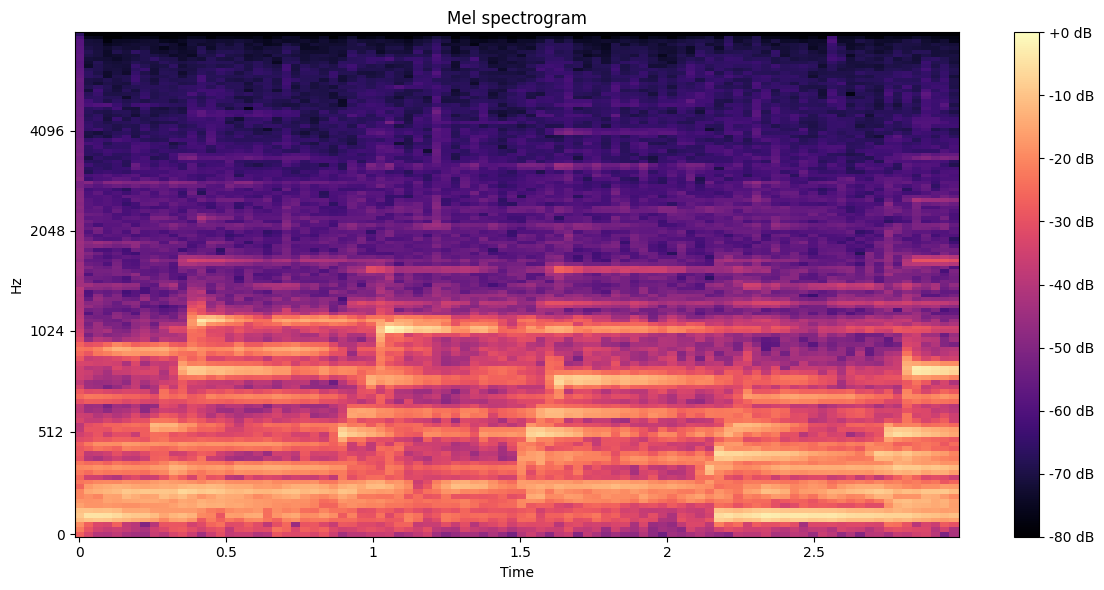

In [16]:
# Get waveform and sampling rate
wave = d["waveform_fixed"].iloc[0]  # or any index
sr = d["sample_rate"].iloc[0]

# Convert to Mel Spectrogram
S = librosa.feature.melspectrogram(y=wave, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram")
plt.tight_layout()
plt.show()



Now you can see what the audio input to the Whisper model looks like after preprocessing.

## Feature extraction

In [17]:
# converting genre or file format  to a format our machine can understand
def embed_prompt_manual(prompt):
    prompt = prompt.lower()
    vec = [0, 0]
    if "lofi" in prompt:
        vec[0] = 1
    if "classical" in prompt:
        vec[1] = 1
    return vec
prompt = "A mix of lo-fi and classical for studying"
embed_prompt_manual(prompt)

[0, 1]

In [18]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [19]:
# function to convert waveform to mel spectogram
def waveform_to_mel(waveform, sr=16000, n_mels=80, hop_length=256, n_fft=1024):
    waveform = np.array(waveform)
    mel_spec = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length,
        n_fft=n_fft,
        power=2.0,
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db  # shape: (n_mels, time_steps)

In [20]:
# Create a new column with Mel spectrograms
d['mel_spectrogram'] = d['waveform_fixed'].apply(lambda x: waveform_to_mel(x, sr=16000))

In [21]:
def split_mel_segments(mel_spectrogram, segment_length=512, hop_size=256):
    """
    Splits mel spectrogram into fixed-length segments.
    
    Parameters:
        mel_spectrogram: np.ndarray (shape: [n_mels, time])
        segment_length: int - desired number of frames per segment
        hop_size: int - step between segments
    
    Returns:
        segments: list of np.ndarray with shape [n_mels, segment_length]
    """
    segments = []
    n_mels, total_frames = mel_spectrogram.shape

    # Pad if shorter than one segment
    if total_frames < segment_length:
        padded = np.pad(mel_spectrogram, ((0, 0), (0, segment_length - total_frames)), mode='constant')
        segments.append(padded)
        return segments

    # Slide window
    for start in range(0, total_frames - segment_length + 1, hop_size):
        end = start + segment_length
        segment = mel_spectrogram[:, start:end]
        segments.append(segment)
    
    return segments


In [22]:
# you can see  working example of previous function -split_mel_segments
all_segments = []

for mel in d['mel_spectrogram']:
    segments = split_mel_segments(mel, segment_length=512, hop_size=256)
    all_segments.extend(segments)


In [23]:
import torch
import torch.nn as nn

class AudioTransformer(nn.Module):
    def __init__(self, input_dim=80, embed_dim=256, num_heads=4, num_layers=4, ff_dim=512, dropout=0.1):
        super(AudioTransformer, self).__init__()
        
        self.input_proj = nn.Linear(input_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 512, embed_dim))  # fixed sequence length
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(embed_dim, 128)  # 128 could be output dimension for next step (e.g., decoder or genre classifier)
    
    def forward(self, x):  # x: [batch, time, mel]
        x = self.input_proj(x)  # [batch, time, embed_dim]
        x = x + self.pos_embed[:, :x.size(1), :]  # Add positional encoding
        x = self.encoder(x)  # [batch, time, embed_dim]
        
        x = x.mean(dim=1)  # global average pooling
        out = self.classifier(x)  # [batch, output_dim]
        return out


We're doing sequence-to-sequence generation, similar to how Transformers work in NLP:

- Input: A mel spectrogram sequence (e.g. 512 frames)
- Output: The next N mel frames (e.g. the next 128 frames)

In [24]:
import torch
from torch.utils.data import Dataset

class MelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, df, segment_length=100):
        self.samples = []  # Will store (input_mel, target_mel, cond_vec)

        for idx, row in df.iterrows():
            mel = waveform_to_mel(row["waveform"])  # (n_frames, mel_dim)
            segments = split_mel_segments(mel, segment_length=segment_length)
            cond_vec = embed_prompt_manual(row['genre'])  


            for segment in segments:
                input_mel = segment[:-1]   # [segment_len - 1, mel_dim]
                target_mel = segment[1:]   # [segment_len - 1, mel_dim]
                self.samples.append((input_mel, target_mel, cond_vec))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_mel, target_mel, cond_vec = self.samples[idx]
        return (
            torch.tensor(input_mel, dtype=torch.float32),      # [T-1, mel_dim]
            torch.tensor(target_mel, dtype=torch.float32),     # [T-1, mel_dim]
            torch.tensor(cond_vec, dtype=torch.float32),       # [cond_dim]
        )



In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerMelGenerator(nn.Module):
    def __init__(self, input_dim=128, model_dim=256, num_heads=4, num_layers=4, ff_dim=512, dropout=0.1, max_len=640, cond_dim=128):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.cond_proj = nn.Linear(cond_dim, model_dim)  # Project condition vector to model_dim
        self.pos_embed = nn.Parameter(torch.randn(1, max_len, model_dim))
        self.cond_dim = cond_dim
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(model_dim, input_dim)

    def forward(self, enc_input, dec_input, cond_vec):
        """
        enc_input: [batch, enc_time, mel]
        dec_input: [batch, dec_time, mel]
        cond_vec: [batch, cond_dim]
        """
        batch_size, enc_len, _ = enc_input.shape
        _, dec_len, _ = dec_input.shape

        # Project and expand the conditioning vector
        cond_encoded = self.cond_proj(cond_vec)               # [batch, model_dim]
        cond_encoded_enc = cond_encoded.unsqueeze(1).expand(-1, enc_len, -1)  # [batch, enc_len, model_dim]
        cond_encoded_dec = cond_encoded.unsqueeze(1).expand(-1, dec_len, -1)  # [batch, dec_len, model_dim]

        # Input projections + positional encoding + conditioning
        enc = self.input_proj(enc_input) + self.pos_embed[:, :enc_len, :] + cond_encoded_enc
        dec = self.input_proj(dec_input) + self.pos_embed[:, :dec_len, :] + cond_encoded_dec

        # Encode
        memory = self.encoder(enc)

        # Create causal mask for decoder
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(dec_len).to(dec.device)

        # Decode
        out = self.decoder(dec, memory, tgt_mask=tgt_mask)

        # Final projection to mel-spectrogram space
        return self.output_proj(out)  # [batch, dec_time, mel]


In [26]:
model = TransformerMelGenerator()
print(model.cond_dim) 

128


In [27]:
# Training phase
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example cond_dim = 2 for one-hot genre embedding
cond_dim = 2  # Update based on your embedding vector size

# Prepare dataset and dataloader
dataset = MelSpectrogramDataset(d, segment_length=128)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Updated model with cond_dim
model = TransformerMelGenerator(input_dim=128, cond_dim=cond_dim, model_dim=256, num_heads=4, num_layers=4, ff_dim=512, dropout=0.1, max_len=640)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0.0

    for src, tgt, cond_vec in dataloader:  # 🚨 Updated
        src = src.to(device)                      # [batch, time, mel]
        tgt = tgt.to(device)                      # [batch, time, mel]
        cond_vec = cond_vec.to(device).float()    # [batch, cond_dim]

        output = model(src, tgt[:, :-1, :], cond_vec)  # 🧠 Add cond_vec
        loss = F.mse_loss(output, tgt[:, 1:, :])        # Predict next frame

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")



Epoch 1, Loss: 2351.5612
Epoch 2, Loss: 1449.3472
Epoch 3, Loss: 818.6099
Epoch 4, Loss: 465.0778
Epoch 5, Loss: 273.9354
Epoch 6, Loss: 178.7903
Epoch 7, Loss: 132.3486
Epoch 8, Loss: 102.5876
Epoch 9, Loss: 85.8843
Epoch 10, Loss: 72.4981


In [28]:
torch.save(model.state_dict(), "model_checkpoint.pt")

In [29]:

def generate_future_frames(model, mel_segment, cond_vec, predict_frames=128, device='cpu'):
    """
    mel_segment: torch.Tensor, shape [n_mels, input_len] e.g. [80, 512]
    """
    model.to(device)
    model.eval()

    input_len = mel_segment.shape[1]  # time dimension
    mel_dim = mel_segment.shape[0]

    # Prepare encoder input: transpose and add batch dimension [1, time, mel_dim]
    enc_input = mel_segment.T.unsqueeze(0).to(device)  # [1, time, mel]

    # Position embedding for encoder
    if input_len > model.pos_embed.size(1):
        pos_embed = torch.nn.functional.interpolate(
            model.pos_embed.permute(0, 2, 1),
            size=input_len,
            mode='linear',
            align_corners=False
        ).permute(0, 2, 1)
    else:
        pos_embed = model.pos_embed[:, :input_len, :]

    # Project encoder input with input_proj
    # Check model.input_proj expects input_dim = mel_dim (e.g. 80)
    enc_proj = model.input_proj(enc_input) + pos_embed  # [1, time, model_dim]

    # Handle conditioning vector
    if cond_vec is not None:
        cond_vec = cond_vec.to(device).float()
        if cond_vec.dim() == 1:
            cond_vec = cond_vec.unsqueeze(0)  # [1, cond_dim]
        cond_vec = cond_vec.unsqueeze(1).expand(-1, enc_proj.size(1), -1)  # [1, time, cond_dim]
        enc_proj = enc_proj + cond_vec

    with torch.no_grad():
        memory = model.encoder(enc_proj)

    generated = enc_input[:, -1:, :]  # last frame from encoder input
    all_gen = []

    for t in range(predict_frames):
        dec_len = generated.size(1)
        if dec_len > model.pos_embed.size(1):
            dec_pos_embed = torch.nn.functional.interpolate(
                model.pos_embed.permute(0, 2, 1),
                size=dec_len,
                mode='linear',
                align_corners=False
            ).permute(0, 2, 1)
        else:
            dec_pos_embed = model.pos_embed[:, :dec_len, :]

        dec_proj = model.input_proj(generated) + dec_pos_embed
        tgt_mask = torch.triu(torch.ones((dec_len, dec_len), device=device), diagonal=1).bool()

        with torch.no_grad():
            out = model.decoder(dec_proj, memory, tgt_mask=tgt_mask)
            out = model.output_proj(out)
            next_frame = out[:, -1:, :]

        generated = torch.cat([generated, next_frame], dim=1)
        all_gen.append(next_frame.squeeze(0).squeeze(0))

    generated_seq = torch.stack(all_gen, dim=1).cpu()
    full_mel = torch.cat([mel_segment.cpu(), generated_seq], dim=1)

    return full_mel


In [38]:
import librosa
import torch
import numpy as np

# --- Load a short audio clip ---
# Keep it short (e.g. 1–2 seconds). You can crop a longer clip if needed.
audio_path = "/Users/pratiibhas/Documents/Deep Learning/Projects/extracted_audio/split_clips/4 HOURS STUDY GIRL - Cozy lofi music and rain in background [l-2hOKIrIyI]/4 HOURS STUDY GIRL - Cozy lofi music and rain in background [l-2hOKIrIyI]_clip_001.wav"  # <-- your input audio file
y, sr = librosa.load(audio_path, sr=22050)

# --- Generate mel spectrogram ---
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # Shape: [80, time_frames]

# --- Optionally normalize (depends on how your model was trained) ---
# mel_db = (mel_db - mel_db.mean()) / mel_db.std()

# --- Convert to torch tensor and save ---
mel_tensor = torch.tensor(mel_db, dtype=torch.float32)
torch.save(mel_tensor, "seed_mel.pt")

print("✅ Saved seed mel-spectrogram to seed_mel.pt with shape:", mel_tensor.shape)



✅ Saved seed mel-spectrogram to seed_mel.pt with shape: torch.Size([80, 2584])


In [42]:
mel_segment = torch.load("seed_mel.pt")  # This should return a tensor, NOT a string
mel_tensor = torch.tensor(mel_db, dtype=torch.float32)  # shape: [80, T]
mel_tensor = mel_tensor.T.unsqueeze(0)  # shape: [1, T, 80]


In [49]:
mel_tensor = mel_tensor[:, :640, :]  # shape: [1, 640, 80]
enc_proj = nn.Linear(80, 256)
enc_input = enc_proj(mel_tensor)  # shape: [1, 640, 256]


In [45]:
enc_input.shape

torch.Size([1, 640, 256])

In [46]:
import re
import torch.nn as nn

# Very simple tokenizer (split by spaces, remove punctuation)
def simple_tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

# Example vocab (extend based on your dataset)
vocab = {'a':0, 'calm':1, 'night':2, 'study':3, 'music':4, 'lofi':5, 'and':6, 'classical':7, 'mix':8, '<unk>':9}
vocab_size = len(vocab)
embed_dim = model.cond_dim  # Use same dim as model expects

embedding = nn.Embedding(vocab_size, embed_dim)

# Tokenize and embed prompt
prompt = "A calm night study music lofi and classical mix"
tokens = simple_tokenize(prompt)
token_ids = torch.tensor([[vocab.get(tok, vocab['<unk>']) for tok in tokens]])  # shape: [1, seq_len]
cond_vec = embedding(token_ids).mean(dim=1)  # shape: [1, embed_dim]


In [50]:
input_len = mel_segment.shape[1]
pos_embed = model.pos_embed[:, :input_len, :]  # [1, time, model_dim]

print("enc_input shape:", enc_input.shape)
print("pos_embed shape:", pos_embed.shape)


enc_input shape: torch.Size([1, 640, 256])
pos_embed shape: torch.Size([1, 640, 256])


In [51]:
# Project encoder input to model_dim
enc_proj = model.input_proj(enc_input)  # shape: [1, 2584, 256]

# Interpolate positional embeddings to match input_len (2584)
if input_len > model.pos_embed.size(1):
    pos_embed = torch.nn.functional.interpolate(
        model.pos_embed.permute(0, 2, 1),  # [1, 256, 640]
        size=input_len,                    # 2584
        mode='linear',
        align_corners=False
    ).permute(0, 2, 1)  # back to [1, 2584, 256]
else:
    pos_embed = model.pos_embed[:, :input_len, :]  # [1, input_len, 256]

# Add positional embedding to projected input
enc_proj = enc_proj + pos_embed


RuntimeError: mat1 and mat2 shapes cannot be multiplied (640x256 and 128x256)

In [56]:
import torch
import numpy as np
import librosa
import soundfile as sf
import torch.nn.functional as F


input_len = enc_input.shape[1]

# Project input to model_dim
mel_tensor = mel_tensor[:, :640, :]  # shape: [1, 640, 80]
enc_proj = nn.Linear(80, 256)
enc_input = enc_proj(mel_tensor)  # shape: [1, 640, 256]

# Handle positional embeddings
if input_len > model.pos_embed.size(1):
    pos_embed = F.interpolate(
        model.pos_embed.permute(0, 2, 1),  # [1, model_dim, max_len]
        size=input_len,                   # interpolate to match time steps
        mode='linear',
        align_corners=False
    ).permute(0, 2, 1)  # back to [1, time, model_dim]
else:
    pos_embed = model.pos_embed[:, :input_len, :]  # slice to match

# Add positional embeddings
enc_proj = enc_proj + pos_embed

# Call frame generation function
full_mel = generate_future_frames(model, mel_segment.unsqueeze(0), cond_vec, predict_frames=128, device=device)

# Transpose if needed: mel shape should be [n_mels=80, time]
if full_mel.shape[0] != 80:
    full_mel = full_mel.T

# Convert mel-spectrogram to power (inverse of dB)
mel_db = full_mel.cpu().numpy()
mel_db = np.clip(mel_db, a_min=1e-5, a_max=None)
mel_power = librosa.db_to_power(mel_db)

# Convert mel to waveform
sr = 22050  # Adjust if different
waveform = librosa.feature.inverse.mel_to_audio(
    mel_power,
    sr=sr,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
)

# Save to WAV
sf.write("generated_audio.wav", waveform, samplerate=sr)
print("✅ Audio saved as generated_audio.wav")


TypeError: unsupported operand type(s) for +: 'Linear' and 'Tensor'

In [ ]:
import torch
import librosa
import numpy as np
import soundfile as sf

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Step 1: Load audio and create mel spectrogram with correct mel bins ---
audio_path = "extracted_audio/split_clips/4 Hours Chopin for Studying, Concentration & Relaxation [4fezP875xOQ]/4 Hours Chopin for Studying, Concentration & Relaxation [4fezP875xOQ]_clip_001.wav"
y, sr = librosa.load(audio_path, sr=22050)

# Make sure n_mels matches model.input_proj.in_features, assumed 128 here
n_mels = 128

mel_spec = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=1024,
    hop_length=256,
    n_mels=n_mels
)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # shape: [n_mels, time_steps]

# --- Step 2: Convert mel spectrogram to torch tensor ---
# Transpose so shape is [time_steps, n_mels] then add batch dim -> [1, time_steps, n_mels]
mel_tensor = torch.tensor(mel_db.T, dtype=torch.float32).unsqueeze(0).to(device)  

# --- Step 3: Trim or pad time dimension to max length supported by model ---
max_len = model.pos_embed.shape[1]  # e.g. 640 time steps supported

if mel_tensor.shape[1] > max_len:
    mel_tensor = mel_tensor[:, :max_len, :]
else:
    # optionally pad with zeros if too short (depends on your model)
    pad_len = max_len - mel_tensor.shape[1]
    if pad_len > 0:
        padding = torch.zeros((1, pad_len, n_mels), device=device)
        mel_tensor = torch.cat([mel_tensor, padding], dim=1)

# --- Step 4: Call your model's generation function ---
# Pass mel_tensor raw to generate_future_frames, which internally applies input_proj
full_mel = generate_future_frames(
    model,
    mel_tensor,
    cond_vec,            # your conditioning vector or None
    predict_frames=128,
    device=device
)

# --- Step 5: Post-process generated mel and convert to waveform ---

# full_mel shape should be [1, time, n_mels] or [time, n_mels], transpose if needed
full_mel = full_mel.squeeze(0)  # remove batch dim if present

if full_mel.shape[1] != n_mels:
    full_mel = full_mel.T

# Convert from dB back to power
mel_power = librosa.db_to_power(full_mel.cpu().numpy())

# Inverse mel to waveform
waveform = librosa.feature.inverse.mel_to_audio(
    mel_power,
    sr=sr,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
)

# --- Step 6: Save waveform ---
sf.write("generated_audio.wav", waveform, samplerate=sr)
print("✅ Audio saved as generated_audio.wav")



In [36]:
print(enc_input.shape)

torch.Size([1, 128, 2584])


In [ ]:
mel_tensor = torch.tensor(d['waveform_fixed'], dtype=torch.float32)  # [mel, time]
print(mel_tensor.shape)

torch.Size([1742, 48000])


In [ ]:
mel_segment.shape

torch.Size([128, 2584])

In [ ]:
# If mel_tensor shape is [batch_size, mel_dim, time], pick one sample:
mel_example = mel_tensor[0]  # shape [80, time]
enc_input = mel_segment.T.unsqueeze(0).to(device)  # shape: [1, time, 128]

enc_input

tensor([[[-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         ...,
         [-16.9500, -15.0860, -21.7172,  ..., -73.5214, -72.3007, -80.0000],
         [-17.1494, -15.2372, -21.9110,  ..., -69.9855, -70.5589, -80.0000],
         [-18.2444, -15.7124, -21.2365,  ..., -69.3385, -70.0828, -75.0746]]])

In [ ]:
model.input_proj

Linear(in_features=128, out_features=256, bias=True)

In [ ]:
cond_vec.shape

torch.Size([1, 2])

In [ ]:
generated_mel = generate_future_frames(model, mel_example, predict_frames=128, device='cpu')
generated_mel

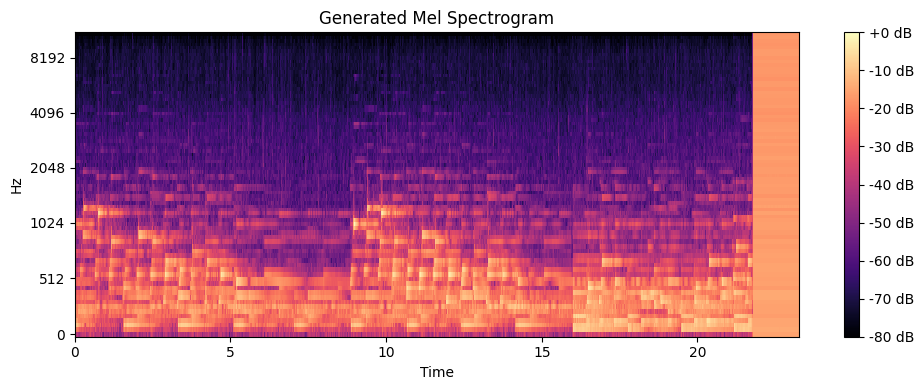

In [ ]:
# Convert tensor to numpy array
mel_np = generated_mel.detach().cpu().numpy()  # detach if tensor requires grad; move to cpu if on GPU

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_np, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Generated Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
def waveform_to_mel(waveform, sr=16000, n_mels=80, hop_length=256, n_fft=1024):
    mel_spec = librosa.feature.melspectrogram(
        y=np.array(waveform),
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length,
        n_fft=n_fft
    )
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec = mel_spec.T  # [time, mel]
    return torch.tensor(mel_spec, dtype=torch.float32)


In [ ]:
import librosa
import librosa.display
import soundfile as sf

# Assume you used same parameters during mel creation
def mel_to_audio(mel, sr=22050, n_fft=1024, hop_length=256, n_iter=60):
    mel = mel.numpy()  # If mel is a PyTorch tensor; remove if mel is already a numpy array
    mel_db = librosa.db_to_power(mel)
    audio = librosa.feature.inverse.mel_to_audio(
        mel_db, sr=sr, n_fft=n_fft, hop_length=hop_length, n_iter=n_iter
    )
    return audio

# Example usage:
audio = mel_to_audio(generated_mel)
sf.write('generated_audio.wav', audio, samplerate=22050)


In [ ]:
def mel_to_audio(mel, sr=22050, n_fft=1024, hop_length=256, n_iter=60):
    # mel = mel.numpy()  # Remove this line since mel is already a numpy array
    mel_db = librosa.db_to_power(mel)
    audio = librosa.feature.inverse.mel_to_audio(
        mel_db, sr=sr, n_fft=n_fft, hop_length=hop_length, n_iter=n_iter
    )
    return audio



In [ ]:
import soundfile as sf
audio = mel_to_audio(generated_mel)
sf.write('generated_audio.wav', audio, samplerate=22050)
